In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%pylab
%matplotlib inline
import os
import math
import time
import tensorflow as tf
from datasets import dataset_utils,cifar10
from tensorflow.contrib import slim

# lrn적용한 버젼!

In [2]:
dropout_keep_prob=0.8
image_size = 32
step=20000
learning_rate=0.0002
train_dir = '/tmp/cifar10/tanh_lrn'

In [3]:
cifar10_data_dir='/media/ramdisk/data/cifar10'

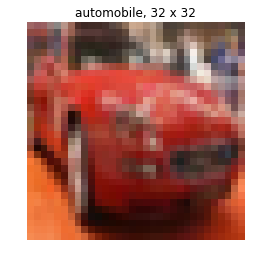

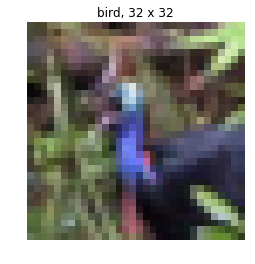

In [4]:
display_step=2

with tf.Graph().as_default(): 
    dataset = cifar10.get_split('train', cifar10_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])

    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(display_step):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()


In [5]:

def cnn_tanh(images, num_classes, is_training):
    #https://github.com/agrawalnishant/tensorflow-1/tree/master/tensorflow/contrib/slim 
    ##vgg와  cifarndet을 참조함
    with slim.arg_scope([slim.max_pool2d], stride=2): 

        net = slim.repeat(images, 2, slim.conv2d, 64, [3, 3], scope='conv1',activation_fn=tf.tanh,normalizer_fn=tf.nn.lrn)
        net = slim.max_pool2d(net, [2, 2], scope='pool1')
        net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2',activation_fn=tf.tanh,normalizer_fn=tf.nn.lrn)
        net = slim.max_pool2d(net, [2, 2], scope='pool2')
        net = slim.repeat(net, 4, slim.conv2d, 256, [3, 3], scope='conv3',activation_fn=tf.tanh,normalizer_fn=tf.nn.lrn)
        net = slim.max_pool2d(net, [2, 2], scope='pool3')
        net = slim.repeat(net, 4, slim.conv2d, 512, [3, 3], scope='conv4',activation_fn=tf.tanh,normalizer_fn=tf.nn.lrn)
        net = slim.max_pool2d(net, [2, 2], scope='pool4')
       
        net = slim.conv2d(net, 512, [2, 2], padding="VALID", scope='fc6')
        net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                         scope='dropout6')
        net = slim.conv2d(net, 512, [1, 1], scope='fc8', activation_fn=None)
        net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                           scope='dropout7')
        net = slim.conv2d(net, num_classes, [1, 1],
                          activation_fn=None,
                          normalizer_fn=None,
                          scope='fc9')
        
        net = tf.squeeze(net, [1,2],name='fc9/squeezed')
        
        return net

In [6]:
from preprocessing import cifarnet_preprocessing

def load_batch(dataset, batch_size=128, height=image_size, width=image_size, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=128,
        common_queue_min=32)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = cifarnet_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=4,
          capacity=4 * batch_size)
    
    return images, images_raw, labels

In [7]:
%%time
# This might take a few minutes.

print('Will save model to %s' % train_dir)

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)

    dataset = cifar10.get_split('train', cifar10_data_dir)
    images, _, labels = load_batch(dataset)
  
    # Create the model:
    logits =cnn_tanh(images, num_classes=dataset.num_classes, is_training=True)
 
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()
    
    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
    
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = slim.learning.create_train_op(total_loss, optimizer)

    # Run the training:
    final_loss = slim.learning.train(
      train_op,
      logdir=train_dir,
      number_of_steps=step, 
          log_every_n_steps=10,
        save_interval_secs=100,
      save_summaries_secs=100)
  
    print('Finished training. Final batch loss %d' % final_loss)

Will save model to /tmp/cifar10/tanh
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/tanh/model.ckpt
INFO:tensorflow:Star

INFO:tensorflow:global step 810: loss = 0.9377 (0.181 sec/step)
INFO:tensorflow:global step 820: loss = 0.9404 (0.180 sec/step)
INFO:tensorflow:global step 830: loss = 0.8113 (0.195 sec/step)
INFO:tensorflow:global step 840: loss = 0.8806 (0.189 sec/step)
INFO:tensorflow:global step 850: loss = 0.8487 (0.191 sec/step)
INFO:tensorflow:global step 860: loss = 0.8054 (0.187 sec/step)
INFO:tensorflow:global step 870: loss = 0.7464 (0.187 sec/step)
INFO:tensorflow:global step 880: loss = 0.7585 (0.193 sec/step)
INFO:tensorflow:global step 890: loss = 0.8702 (0.202 sec/step)
INFO:tensorflow:global step 900: loss = 0.7365 (0.211 sec/step)
INFO:tensorflow:global step 910: loss = 0.9049 (0.189 sec/step)
INFO:tensorflow:global step 920: loss = 0.9636 (0.181 sec/step)
INFO:tensorflow:global step 930: loss = 0.7349 (0.199 sec/step)
INFO:tensorflow:global step 940: loss = 0.8614 (0.199 sec/step)
INFO:tensorflow:global step 950: loss = 0.7461 (0.184 sec/step)
INFO:tensorflow:global step 960: loss = 

INFO:tensorflow:global step 2030: loss = 0.4794 (0.191 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/tanh/model.ckpt
INFO:tensorflow:global_step/sec: 5.08999
INFO:tensorflow:Recording summary at step 2036.
INFO:tensorflow:global step 2040: loss = 0.4557 (0.210 sec/step)
INFO:tensorflow:global step 2050: loss = 0.6138 (0.194 sec/step)
INFO:tensorflow:global step 2060: loss = 0.6720 (0.194 sec/step)
INFO:tensorflow:global step 2070: loss = 0.6054 (0.196 sec/step)
INFO:tensorflow:global step 2080: loss = 0.4944 (0.196 sec/step)
INFO:tensorflow:global step 2090: loss = 0.5431 (0.192 sec/step)
INFO:tensorflow:global step 2100: loss = 0.4969 (0.176 sec/step)
INFO:tensorflow:global step 2110: loss = 0.4398 (0.187 sec/step)
INFO:tensorflow:global step 2120: loss = 0.5053 (0.202 sec/step)
INFO:tensorflow:global step 2130: loss = 0.3743 (0.200 sec/step)
INFO:tensorflow:global step 2140: loss = 0.4486 (0.205 sec/step)
INFO:tensorflow:global step 2150: loss = 0.4851 (0.201 sec/s

INFO:tensorflow:global step 3220: loss = 0.2540 (0.182 sec/step)
INFO:tensorflow:global step 3230: loss = 0.3042 (0.190 sec/step)
INFO:tensorflow:global step 3240: loss = 0.3682 (0.201 sec/step)
INFO:tensorflow:global step 3250: loss = 0.4353 (0.192 sec/step)
INFO:tensorflow:global step 3260: loss = 0.3096 (0.201 sec/step)
INFO:tensorflow:global step 3270: loss = 0.3138 (0.217 sec/step)
INFO:tensorflow:global step 3280: loss = 0.2540 (0.193 sec/step)
INFO:tensorflow:global step 3290: loss = 0.2353 (0.199 sec/step)
INFO:tensorflow:global step 3300: loss = 0.2592 (0.186 sec/step)
INFO:tensorflow:global step 3310: loss = 0.3223 (0.204 sec/step)
INFO:tensorflow:global step 3320: loss = 0.3668 (0.215 sec/step)
INFO:tensorflow:global step 3330: loss = 0.2343 (0.190 sec/step)
INFO:tensorflow:global step 3340: loss = 0.3554 (0.206 sec/step)
INFO:tensorflow:global step 3350: loss = 0.2265 (0.188 sec/step)
INFO:tensorflow:global step 3360: loss = 0.4165 (0.187 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4440: loss = 0.1604 (0.198 sec/step)
INFO:tensorflow:global step 4450: loss = 0.2439 (0.184 sec/step)
INFO:tensorflow:global step 4460: loss = 0.2263 (0.192 sec/step)
INFO:tensorflow:global step 4470: loss = 0.2577 (0.190 sec/step)
INFO:tensorflow:global step 4480: loss = 0.1579 (0.187 sec/step)
INFO:tensorflow:global step 4490: loss = 0.2117 (0.199 sec/step)
INFO:tensorflow:global step 4500: loss = 0.2257 (0.178 sec/step)
INFO:tensorflow:global step 4510: loss = 0.1483 (0.185 sec/step)
INFO:tensorflow:global step 4520: loss = 0.1637 (0.185 sec/step)
INFO:tensorflow:global step 4530: loss = 0.1581 (0.191 sec/step)
INFO:tensorflow:global step 4540: loss = 0.2218 (0.192 sec/step)
INFO:tensorflow:global step 4550: loss = 0.2097 (0.197 sec/step)
INFO:tensorflow:global step 4560: loss = 0.3889 (0.183 sec/step)
INFO:tensorflow:global step 4570: loss = 0.2508 (0.202 sec/step)
INFO:tensorflow:global step 4580: loss = 0.2564 (0.198 sec/step)
INFO:tensorflow:Saving ch

INFO:tensorflow:global step 5640: loss = 0.0882 (0.181 sec/step)
INFO:tensorflow:global step 5650: loss = 0.0833 (0.180 sec/step)
INFO:tensorflow:global step 5660: loss = 0.0904 (0.196 sec/step)
INFO:tensorflow:global step 5670: loss = 0.0887 (0.192 sec/step)
INFO:tensorflow:global step 5680: loss = 0.1446 (0.184 sec/step)
INFO:tensorflow:global step 5690: loss = 0.0463 (0.202 sec/step)
INFO:tensorflow:global step 5700: loss = 0.0986 (0.188 sec/step)
INFO:tensorflow:global step 5710: loss = 0.1694 (0.190 sec/step)
INFO:tensorflow:global step 5720: loss = 0.0699 (0.186 sec/step)
INFO:tensorflow:global step 5730: loss = 0.0820 (0.193 sec/step)
INFO:tensorflow:global step 5740: loss = 0.1982 (0.197 sec/step)
INFO:tensorflow:global step 5750: loss = 0.0861 (0.189 sec/step)
INFO:tensorflow:global step 5760: loss = 0.1686 (0.210 sec/step)
INFO:tensorflow:global step 5770: loss = 0.0997 (0.185 sec/step)
INFO:tensorflow:global step 5780: loss = 0.1414 (0.183 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6870: loss = 0.0973 (0.208 sec/step)
INFO:tensorflow:global step 6880: loss = 0.1777 (0.199 sec/step)
INFO:tensorflow:global step 6890: loss = 0.1284 (0.193 sec/step)
INFO:tensorflow:global step 6900: loss = 0.0639 (0.191 sec/step)
INFO:tensorflow:global step 6910: loss = 0.1001 (0.194 sec/step)
INFO:tensorflow:global step 6920: loss = 0.1538 (0.186 sec/step)
INFO:tensorflow:global step 6930: loss = 0.1320 (0.185 sec/step)
INFO:tensorflow:global step 6940: loss = 0.1496 (0.203 sec/step)
INFO:tensorflow:global step 6950: loss = 0.0771 (0.198 sec/step)
INFO:tensorflow:global step 6960: loss = 0.0589 (0.192 sec/step)
INFO:tensorflow:global step 6970: loss = 0.0301 (0.179 sec/step)
INFO:tensorflow:global step 6980: loss = 0.0774 (0.195 sec/step)
INFO:tensorflow:global step 6990: loss = 0.1397 (0.202 sec/step)
INFO:tensorflow:global step 7000: loss = 0.0750 (0.189 sec/step)
INFO:tensorflow:global step 7010: loss = 0.0391 (0.193 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8100: loss = 0.0663 (0.183 sec/step)
INFO:tensorflow:global step 8110: loss = 0.1479 (0.185 sec/step)
INFO:tensorflow:global step 8120: loss = 0.0716 (0.185 sec/step)
INFO:tensorflow:global step 8130: loss = 0.0284 (0.185 sec/step)
INFO:tensorflow:global step 8140: loss = 0.0596 (0.202 sec/step)
INFO:tensorflow:global step 8150: loss = 0.0233 (0.189 sec/step)
INFO:tensorflow:global step 8160: loss = 0.0368 (0.190 sec/step)
INFO:tensorflow:global step 8170: loss = 0.0910 (0.201 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/tanh/model.ckpt
INFO:tensorflow:Recording summary at step 8172.
INFO:tensorflow:global step 8180: loss = 0.0716 (0.198 sec/step)
INFO:tensorflow:global step 8190: loss = 0.0902 (0.185 sec/step)
INFO:tensorflow:global step 8200: loss = 0.1157 (0.201 sec/step)
INFO:tensorflow:global step 8210: loss = 0.0680 (0.192 sec/step)
INFO:tensorflow:global step 8220: loss = 0.0323 (0.180 sec/step)
INFO:tensorflow:global step 8230: lo

INFO:tensorflow:global step 9310: loss = 0.0417 (0.202 sec/step)
INFO:tensorflow:global step 9320: loss = 0.0439 (0.200 sec/step)
INFO:tensorflow:global step 9330: loss = 0.0606 (0.184 sec/step)
INFO:tensorflow:global step 9340: loss = 0.0780 (0.189 sec/step)
INFO:tensorflow:global step 9350: loss = 0.0697 (0.190 sec/step)
INFO:tensorflow:global step 9360: loss = 0.1094 (0.180 sec/step)
INFO:tensorflow:global step 9370: loss = 0.0561 (0.208 sec/step)
INFO:tensorflow:global step 9380: loss = 0.0197 (0.196 sec/step)
INFO:tensorflow:global step 9390: loss = 0.0304 (0.187 sec/step)
INFO:tensorflow:global step 9400: loss = 0.1070 (0.208 sec/step)
INFO:tensorflow:global step 9410: loss = 0.0281 (0.193 sec/step)
INFO:tensorflow:global step 9420: loss = 0.0621 (0.190 sec/step)
INFO:tensorflow:global step 9430: loss = 0.0978 (0.177 sec/step)
INFO:tensorflow:global step 9440: loss = 0.1170 (0.187 sec/step)
INFO:tensorflow:global step 9450: loss = 0.1100 (0.189 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 10530: loss = 0.1018 (0.202 sec/step)
INFO:tensorflow:global step 10540: loss = 0.0718 (0.188 sec/step)
INFO:tensorflow:global step 10550: loss = 0.1635 (0.208 sec/step)
INFO:tensorflow:global step 10560: loss = 0.0632 (0.202 sec/step)
INFO:tensorflow:global step 10570: loss = 0.1380 (0.203 sec/step)
INFO:tensorflow:global step 10580: loss = 0.1250 (0.218 sec/step)
INFO:tensorflow:global step 10590: loss = 0.0315 (0.207 sec/step)
INFO:tensorflow:global step 10600: loss = 0.0533 (0.181 sec/step)
INFO:tensorflow:global step 10610: loss = 0.0476 (0.186 sec/step)
INFO:tensorflow:global step 10620: loss = 0.1092 (0.187 sec/step)
INFO:tensorflow:global step 10630: loss = 0.0421 (0.197 sec/step)
INFO:tensorflow:global step 10640: loss = 0.1296 (0.207 sec/step)
INFO:tensorflow:global step 10650: loss = 0.0158 (0.193 sec/step)
INFO:tensorflow:global step 10660: loss = 0.0471 (0.190 sec/step)
INFO:tensorflow:global step 10670: loss = 0.0430 (0.193 sec/step)
INFO:tenso

INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/tanh/model.ckpt
INFO:tensorflow:Recording summary at step 11737.
INFO:tensorflow:global step 11740: loss = 0.0648 (0.207 sec/step)
INFO:tensorflow:global step 11750: loss = 0.0695 (0.193 sec/step)
INFO:tensorflow:global step 11760: loss = 0.0218 (0.194 sec/step)
INFO:tensorflow:global step 11770: loss = 0.0255 (0.205 sec/step)
INFO:tensorflow:global step 11780: loss = 0.1038 (0.193 sec/step)
INFO:tensorflow:global step 11790: loss = 0.0607 (0.192 sec/step)
INFO:tensorflow:global step 11800: loss = 0.0745 (0.187 sec/step)
INFO:tensorflow:global step 11810: loss = 0.0305 (0.187 sec/step)
INFO:tensorflow:global step 11820: loss = 0.0315 (0.207 sec/step)
INFO:tensorflow:global step 11830: loss = 0.0832 (0.195 sec/step)
INFO:tensorflow:global step 11840: loss = 0.0728 (0.186 sec/step)
INFO:tensorflow:global step 11850: loss = 0.0667 (0.199 sec/step)
INFO:tensorflow:global step 11860: loss = 0.0116 (0.178 sec/step)
INFO:tensorflow:global

INFO:tensorflow:global step 12930: loss = 0.0498 (0.194 sec/step)
INFO:tensorflow:global step 12940: loss = 0.0964 (0.200 sec/step)
INFO:tensorflow:global step 12950: loss = 0.1732 (0.211 sec/step)
INFO:tensorflow:global step 12960: loss = 0.0617 (0.212 sec/step)
INFO:tensorflow:global step 12970: loss = 0.0533 (0.178 sec/step)
INFO:tensorflow:global step 12980: loss = 0.0541 (0.190 sec/step)
INFO:tensorflow:global step 12990: loss = 0.0216 (0.196 sec/step)
INFO:tensorflow:global step 13000: loss = 0.0276 (0.188 sec/step)
INFO:tensorflow:global step 13010: loss = 0.0903 (0.191 sec/step)
INFO:tensorflow:global step 13020: loss = 0.0965 (0.199 sec/step)
INFO:tensorflow:global step 13030: loss = 0.0069 (0.205 sec/step)
INFO:tensorflow:global step 13040: loss = 0.0804 (0.188 sec/step)
INFO:tensorflow:global step 13050: loss = 0.0275 (0.197 sec/step)
INFO:tensorflow:global step 13060: loss = 0.0379 (0.182 sec/step)
INFO:tensorflow:global step 13070: loss = 0.0233 (0.198 sec/step)
INFO:tenso

INFO:tensorflow:global step 14140: loss = 0.0038 (0.186 sec/step)
INFO:tensorflow:global step 14150: loss = 0.0414 (0.194 sec/step)
INFO:tensorflow:global step 14160: loss = 0.1744 (0.197 sec/step)
INFO:tensorflow:global step 14170: loss = 0.0261 (0.203 sec/step)
INFO:tensorflow:global step 14180: loss = 0.0270 (0.184 sec/step)
INFO:tensorflow:global step 14190: loss = 0.1066 (0.191 sec/step)
INFO:tensorflow:global step 14200: loss = 0.0065 (0.183 sec/step)
INFO:tensorflow:global step 14210: loss = 0.0328 (0.196 sec/step)
INFO:tensorflow:global step 14220: loss = 0.0047 (0.184 sec/step)
INFO:tensorflow:global step 14230: loss = 0.0224 (0.191 sec/step)
INFO:tensorflow:global step 14240: loss = 0.0574 (0.182 sec/step)
INFO:tensorflow:global step 14250: loss = 0.0319 (0.193 sec/step)
INFO:tensorflow:global step 14260: loss = 0.0783 (0.196 sec/step)
INFO:tensorflow:global step 14270: loss = 0.0480 (0.191 sec/step)
INFO:tensorflow:global step 14280: loss = 0.0706 (0.191 sec/step)
INFO:tenso

INFO:tensorflow:global step 15330: loss = 0.0113 (0.211 sec/step)
INFO:tensorflow:global step 15340: loss = 0.0220 (0.203 sec/step)
INFO:tensorflow:global step 15350: loss = 0.0587 (0.199 sec/step)
INFO:tensorflow:global step 15360: loss = 0.0147 (0.203 sec/step)
INFO:tensorflow:global step 15370: loss = 0.0534 (0.199 sec/step)
INFO:tensorflow:global step 15380: loss = 0.0385 (0.193 sec/step)
INFO:tensorflow:global step 15390: loss = 0.0360 (0.199 sec/step)
INFO:tensorflow:global step 15400: loss = 0.0262 (0.214 sec/step)
INFO:tensorflow:global step 15410: loss = 0.0576 (0.191 sec/step)
INFO:tensorflow:global step 15420: loss = 0.0260 (0.186 sec/step)
INFO:tensorflow:global step 15430: loss = 0.0603 (0.178 sec/step)
INFO:tensorflow:global step 15440: loss = 0.0334 (0.183 sec/step)
INFO:tensorflow:global step 15450: loss = 0.0124 (0.181 sec/step)
INFO:tensorflow:global step 15460: loss = 0.0393 (0.184 sec/step)
INFO:tensorflow:global step 15470: loss = 0.0222 (0.201 sec/step)
INFO:tenso

INFO:tensorflow:global step 16540: loss = 0.0087 (0.202 sec/step)
INFO:tensorflow:global step 16550: loss = 0.0239 (0.190 sec/step)
INFO:tensorflow:global step 16560: loss = 0.1101 (0.205 sec/step)
INFO:tensorflow:global step 16570: loss = 0.0369 (0.182 sec/step)
INFO:tensorflow:global step 16580: loss = 0.0238 (0.194 sec/step)
INFO:tensorflow:global step 16590: loss = 0.0278 (0.190 sec/step)
INFO:tensorflow:global step 16600: loss = 0.0271 (0.179 sec/step)
INFO:tensorflow:global step 16610: loss = 0.0255 (0.192 sec/step)
INFO:tensorflow:global step 16620: loss = 0.0095 (0.201 sec/step)
INFO:tensorflow:global step 16630: loss = 0.0179 (0.203 sec/step)
INFO:tensorflow:global step 16640: loss = 0.0069 (0.198 sec/step)
INFO:tensorflow:global step 16650: loss = 0.0246 (0.184 sec/step)
INFO:tensorflow:global step 16660: loss = 0.0239 (0.194 sec/step)
INFO:tensorflow:global step 16670: loss = 0.0299 (0.195 sec/step)
INFO:tensorflow:global step 16680: loss = 0.0204 (0.184 sec/step)
INFO:tenso

INFO:tensorflow:global step 17750: loss = 0.0541 (0.193 sec/step)
INFO:tensorflow:global step 17760: loss = 0.0338 (0.182 sec/step)
INFO:tensorflow:global step 17770: loss = 0.0238 (0.191 sec/step)
INFO:tensorflow:global step 17780: loss = 0.0409 (0.205 sec/step)
INFO:tensorflow:global step 17790: loss = 0.0062 (0.183 sec/step)
INFO:tensorflow:global step 17800: loss = 0.0260 (0.197 sec/step)
INFO:tensorflow:global step 17810: loss = 0.0061 (0.195 sec/step)
INFO:tensorflow:global step 17820: loss = 0.0640 (0.183 sec/step)
INFO:tensorflow:global step 17830: loss = 0.0437 (0.207 sec/step)
INFO:tensorflow:global step 17840: loss = 0.0128 (0.194 sec/step)
INFO:tensorflow:global step 17850: loss = 0.0066 (0.200 sec/step)
INFO:tensorflow:global step 17860: loss = 0.0298 (0.189 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/tanh/model.ckpt
INFO:tensorflow:global step 17870: loss = 0.0022 (0.190 sec/step)
INFO:tensorflow:Recording summary at step 17870.
INFO:tensorflow:global

INFO:tensorflow:global step 18940: loss = 0.0897 (0.211 sec/step)
INFO:tensorflow:global step 18950: loss = 0.0200 (0.202 sec/step)
INFO:tensorflow:global step 18960: loss = 0.0704 (0.204 sec/step)
INFO:tensorflow:global step 18970: loss = 0.0252 (0.191 sec/step)
INFO:tensorflow:global step 18980: loss = 0.0361 (0.188 sec/step)
INFO:tensorflow:global step 18990: loss = 0.0774 (0.189 sec/step)
INFO:tensorflow:global step 19000: loss = 0.0398 (0.202 sec/step)
INFO:tensorflow:global step 19010: loss = 0.0615 (0.207 sec/step)
INFO:tensorflow:global step 19020: loss = 0.0179 (0.202 sec/step)
INFO:tensorflow:global step 19030: loss = 0.0033 (0.191 sec/step)
INFO:tensorflow:global step 19040: loss = 0.1108 (0.203 sec/step)
INFO:tensorflow:global step 19050: loss = 0.0378 (0.194 sec/step)
INFO:tensorflow:global step 19060: loss = 0.0182 (0.189 sec/step)
INFO:tensorflow:global step 19070: loss = 0.0102 (0.183 sec/step)
INFO:tensorflow:global step 19080: loss = 0.0104 (0.202 sec/step)
INFO:tenso

In [8]:
%%time

# This might take a few minutes.
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.DEBUG)
    
    dataset = cifar10.get_split('test', cifar10_data_dir)
    images, _, labels = load_batch(dataset)
    
    logits = cnn_tanh(images, num_classes=dataset.num_classes, is_training=False)
    predictions = tf.argmax(logits, 1)
    
    # Define the metrics:
    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        'eval/mse':slim.metrics.streaming_mean_squared_error(predictions, labels),
        'eval/Accuracy': slim.metrics.streaming_accuracy(predictions, labels),
        'eval/TruePositives': slim.metrics.streaming_true_positives(predictions, labels),        
        'eval/TrueNegatives': slim.metrics.streaming_true_negatives(predictions, labels),
        'eval/FalsePositives': slim.metrics.streaming_false_positives(predictions, labels),
        'eval/FalseNegatives': slim.metrics.streaming_false_negatives(predictions, labels),
        'eval/Recall5': slim.metrics.streaming_sparse_recall_at_k(logits, labels, 5),
    })

    print('Running evaluation Loop...')
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    metric_values = slim.evaluation.evaluate_once(
        master='',
        checkpoint_path=checkpoint_path,
        logdir=train_dir,
        eval_op=list(names_to_updates.values()),
        final_op=list(names_to_values.values())
    )

    names_to_values = dict(zip(names_to_values.keys(), metric_values))
    for name in names_to_values:
        print('%s: %f' % (name, names_to_values[name]))


Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the inputs of labels and predictions have been switched.
Running evaluation Loop...
INFO:tensorflow:Starting evaluation at 2017-12-03-09:04:08
INFO:tensorflow:Restoring parameters from /tmp/cifar10/tanh/model.ckpt-20000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-03-09:04:09
eval/Accuracy: 0.796875
eval/TrueNegatives: 8.000000
eval/TruePositives: 118.000000
eval/FalseNegatives: 2.000000
eval/mse: 3.023438
eval/FalsePositives: 0.000000
eval/Recall5: 0.976562
CPU times: user 1.82 s, sys: 308 ms, total: 2.13 s
Wall time: 1.22 s


INFO:tensorflow:Restoring parameters from /tmp/cifar10/tanh/model.ckpt-20000


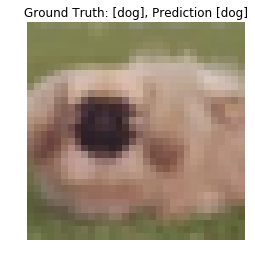

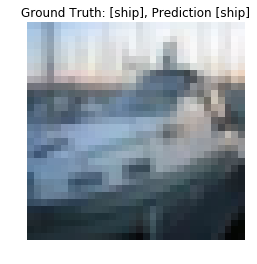

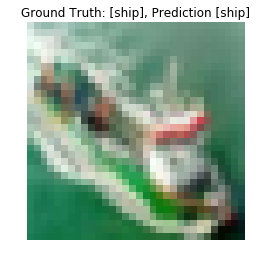

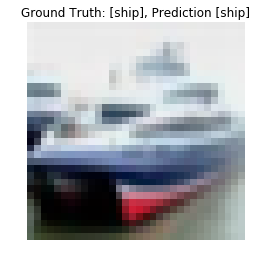

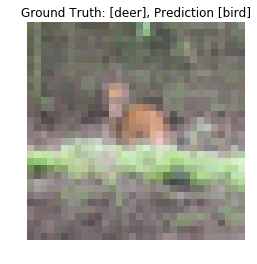

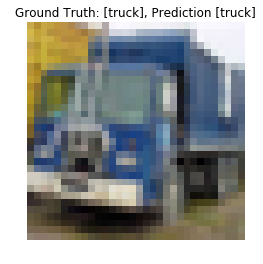

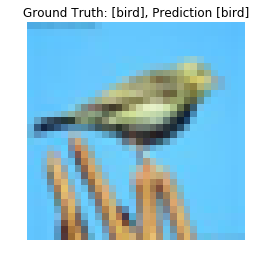

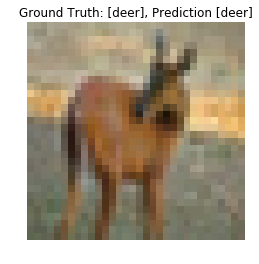

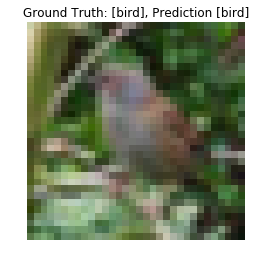

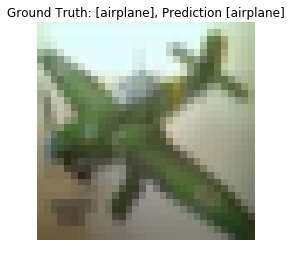

CPU times: user 3.28 s, sys: 1.72 s, total: 5 s
Wall time: 1.62 s


In [9]:
%%time
batch_size = 10
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = cifar10.get_split('test',cifar10_data_dir)
    images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    logits = cnn_tanh(images, num_classes=dataset.num_classes, is_training=True)
    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.local_variables_initializer())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
    
            for i in range(batch_size): 
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = dataset.labels_to_names[predicted_label]
                true_name = dataset.labels_to_names[true_label]
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()